# Chapter 3

In [1]:
from unlikely.misc import hpdi

In [2]:
import numpy as np
import pandas as pd
from unlikely.models import Models, Model
from unlikely.priors import Beta
from unlikely.engine import abc_smc
from unlikely.misc import create_images_from_data


num_particles = 2000
obs = {
    'water': 6,
    'land': 3
}

epsilons_list = [[0]]


def distance(x,y):
    """
    Compare the number of ones in one vs. the other.
    """
    return abs(x['water'] - y['water'])

def simulate(priors, obs):
    """
    Data is binomially distributed.
    """
    return {
        'water': np.random.binomial(
            n=1, 
            p=priors['beta'], 
            size=obs['water'] + obs['land']
        ).sum()
    }

for row, epsilons in enumerate(epsilons_list):
    models = Models(
        [
            Model(
                name='flat prior',
                priors=[
                    Beta(alpha=1, beta=1, name="beta"),
                ],
                simulate=simulate,
                prior_model_proba=1,
            ),
        ]
    )

    # Update with 1st batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models,
        obs=obs,
        distance=distance,
    )

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 282.57it/s]


(<Figure size 576x288 with 1 Axes>,
 <AxesSubplot:title={'center':'6 water, 3 land'}, ylabel='Density'>)

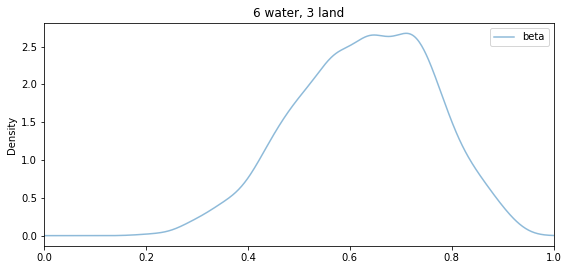

In [3]:
create_images_from_data(
    data={
        'title': '',
        'data': [
            [
                {
                    'title': '6 water, 3 land',
                    'data': [
                        pd.DataFrame(models[0].prev_accepted_proposals)
                    ]
                }
            ]
        ]
    },
    xlim=(0,1),
    figsize_mult=(8,4)
)

In [4]:
posterior = models[0].prev_accepted_proposals

## 3E1. 
How much posterior probability lies below p = 0.2?  


In [5]:
(posterior < 0.2).sum() / posterior.shape[0]

beta    0.0005
dtype: float64


## 3E2. 
How much posterior probability lies above p = 0.8?  


In [6]:
(posterior > 0.8).sum() / posterior.shape[0]

beta    0.091
dtype: float64


## 3E3. 

How much posterior probability lies between p = 0.2 and p = 0.8?  

In [7]:
1 - (posterior < 0.2).sum() / posterior.shape[0] \
- (posterior > 0.8).sum() / posterior.shape[0]

beta    0.9085
dtype: float64

## 3E4. 

20% of the posterior probability lies below which value of p?  



In [8]:
np.quantile(posterior, q=0.2)

0.5085782763883506

## 3E5. 

20% of the posterior probability lies above which value of p?  



In [9]:
np.quantile(posterior, q=0.8)

0.7463579272082889

## 3E6. 

Which values of p contain the narrowest interval equal to 66% of the posterior probability?  



In [10]:
two_thirds_hpdi = hpdi(array=posterior.values, proba=0.66)
two_thirds_hpdi

(array([0.51782717]), array([0.77913494]))

## 3E7. 

Which values of p contain 66% of the posterior probability, assuming equal posterior probability both below and above the interval?  


In [11]:
two_thirds_within = np.quantile(posterior, 1.0/6), np.quantile(posterior, 5.0/6)
two_thirds_within

(0.490587448876584, 0.7605368556692004)

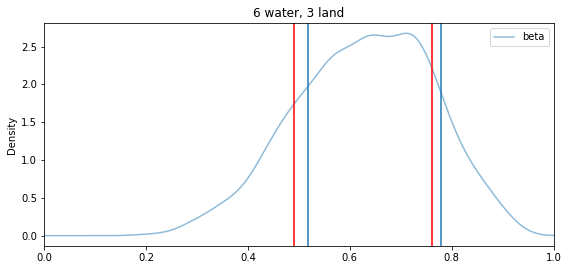

In [12]:
fig, ax = create_images_from_data(
    data={
        'title': '',
        'data': [
            [
                {
                    'title': '6 water, 3 land',
                    'data': [
                        pd.DataFrame(models[0].prev_accepted_proposals)
                    ]
                }
            ]
        ]
    },
    xlim=(0,1),
    figsize_mult=(8,4)
)

ax.axvline(x=two_thirds_hpdi[0][0])
ax.axvline(x=two_thirds_hpdi[1][0])
ax.axvline(x=two_thirds_within[0], color='r')
ax.axvline(x=two_thirds_within[1], color='r')


## 3M1. 

Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before.  



In [34]:
import numpy as np
import pandas as pd
from unlikely.models import Models, Model
from unlikely.priors import Beta
from unlikely.engine import abc_smc
from unlikely.misc import create_images_from_data


num_particles = 10000
obs = {
    'water': 8,
    'land': 7
}

epsilons_list = [[0]]


def distance(x,y):
    """
    Compare the number of ones in one vs. the other.
    """
    return abs(x['water'] - y['water'])

def simulate(priors, obs):
    """
    Data is binomially distributed.
    """
    return {
        'water': np.random.binomial(
            n=1, 
            p=priors['beta'], 
            size=obs['water'] + obs['land']
        ).sum()
    }
flat_prior_model = Model(
    name='flat prior',
    priors=[
        Beta(alpha=1, beta=1, name="beta"),
    ],
    simulate=simulate,
    prior_model_proba=1,
)

for row, epsilons in enumerate(epsilons_list):
    models = Models(
        [
            flat_prior_model
        ]
    )

    # Update with 1st batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models,
        obs=obs,
        distance=distance,
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:50<00:00, 196.53it/s]


## 3M2. 

Draw 10,000 samples from the grid approximation from above. Then use the samples to calculate the 90% HPDI for p.  



In [35]:
hdpi_90_percent = hpdi(proba=0.9, array=flat_prior_model.prev_accepted_proposals.values)

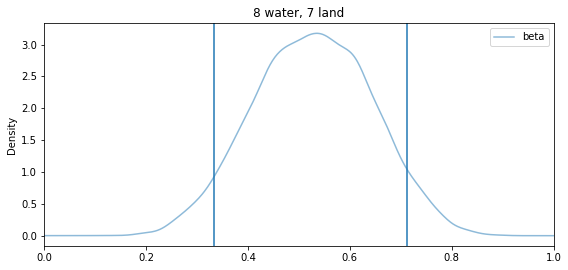

In [36]:
fig, ax = create_images_from_data(
    data={
        'title': '',
        'data': [
            [
                {
                    'title': '8 water, 7 land',
                    'data': [
                        pd.DataFrame(flat_prior_model.prev_accepted_proposals)
                    ]
                }
            ]
        ]
    },
    xlim=(0,1),
    figsize_mult=(8,4)
)

ax.axvline(hdpi_90_percent[0][0])
ax.axvline(hdpi_90_percent[1][0])

## 3M3. 

Construct a posterior predictive check for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in p. What is the probability of observing  8 water in 15 tosses?  



In [37]:
(
    flat_prior_model.prev_accepted_proposals.apply(
        lambda x: np.random.binomial(n=15, p=x['beta']), axis=1
    ) == 8
).mean()

0.1469

## 3M4. 

Using the posterior distribution constructed from the new (8/15) data, now calculate the probability of observing 6 water in 9 tosses.  

In [38]:
(
    flat_prior_model.prev_accepted_proposals.apply(
        lambda x: np.random.binomial(n=9, p=x['beta']), axis=1
    ) == 6
).mean()

0.1806

## 3M5. 

Start over at 3M1, but now use a prior that is zero below p = 0.5 and a constant above p = 0.5.  This corresponds to prior information that a majority of the Earth’s surface is water. Repeat each  problem above and compare the inferences. What difference does the better prior make? If it helps,  compare inferences (using both priors) to the true value p = 0.7.  

In [39]:
import numpy as np
import pandas as pd
from unlikely.models import Models, Model
from unlikely.priors import Uniform
from unlikely.engine import abc_smc
from unlikely.misc import create_images_from_data


num_particles = 10000
obs = {
    'water': 8,
    'land': 7
}

epsilons_list = [[0]]


def distance(x,y):
    """
    Compare the number of ones in one vs. the other.
    """
    return abs(x['water'] - y['water'])

def simulate(priors, obs):
    """
    Data is binomially distributed.
    """
    return {
        'water': np.random.binomial(
            n=1, 
            p=priors['uniform from 0.5 to 1'], 
            size=obs['water'] + obs['land']
        ).sum()
    }

for row, epsilons in enumerate(epsilons_list):
    model_uniform_from_half_to_1 = Model(
        name='flat prior',
        priors=[
            Uniform(alpha=0.5, beta=1, name="uniform from 0.5 to 1"),
        ],
        simulate=simulate,
        prior_model_proba=1,
    )
    
    models = Models(
        [
            model_uniform_from_half_to_1
        ]
    )

    # Update with 1st batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models,
        obs=obs,
        distance=distance,
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 219.72it/s]


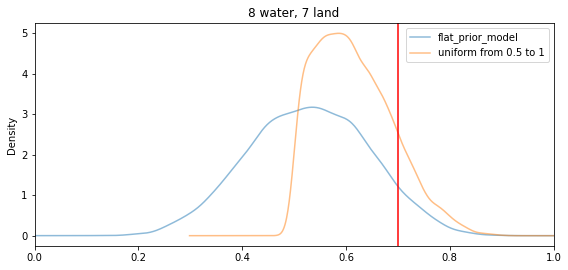

In [46]:
fig, ax = create_images_from_data(
    data={
        'title': '',
        'data': [
            [
                {
                    'title': '8 water, 7 land',
                    'data': [
                        pd.DataFrame(flat_prior_model.prev_accepted_proposals).rename(
                            columns={
                                'beta': 'flat_prior_model'
                            }
                        ),
                        pd.DataFrame(model_uniform_from_half_to_1.prev_accepted_proposals).rename(
                            columns={   
                                'beta': 'uniform_from_half_to_1'
                            }
                        )
                        
                    ]
                }
            ]
        ]
    },
    xlim=(0,1),
    figsize_mult=(8,4)
)
ax.axvline(0.7, color='r')


The model with the prior "Uniform from 0.5 to 1" puts more weight to the correct value of 0.7, compared to the model that has a flat distribution throughout 0 to 1.

## 3M6.

Suppose you want to estimate the Earth’s proportion of water very precisely. Specifically, you  want the 99% percentile interval of the posterior distribution of p to be only 0.05 wide. This means  the distance between the upper and lower bound of the interval should be 0.05. How many times will  you have to toss the globe to do this?  



In [50]:
import numpy as np
import pandas as pd
from unlikely.models import Models, Model
from unlikely.priors import Uniform
from unlikely.engine import abc_smc
from unlikely.misc import create_images_from_data


num_particles = 10000
obs = {
    'water': 700,
    'land': 300
}

epsilons_list = [[500, 250, 125, 67, 33, 15, 7, 3, 0]]


def distance(x,y):
    """
    Compare the number of ones in one vs. the other.
    """
    return abs(x['water'] - y['water'])

def simulate(priors, obs):
    """
    Data is binomially distributed.
    """
    return {
        'water': np.random.binomial(
            n=1, 
            p=priors['flat prior'], 
            size=obs['water'] + obs['land']
        ).sum()
    }

for row, epsilons in enumerate(epsilons_list):
    model_uniform_from_half_to_1 = Model(
        name='flat prior',
        priors=[
            Uniform(alpha=0, beta=1, name="flat prior"),
        ],
        simulate=simulate,
        prior_model_proba=1,
    )
    
    models = Models(
        [
            model_uniform_from_half_to_1
        ]
    )

    # Update with 1st batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models,
        obs=obs,
        distance=distance,
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [2:06:17<00:00,  1.32it/s]


In [55]:
hpdi(
    array=model_uniform_from_half_to_1.prev_accepted_proposals.values.reshape(1,10000)[0],
    proba=0.99
)

(0.6615890099426762, 0.7358289896042531)

Hard. The Hard problems here all use the data below. These data

These data indicate the gender (male=1, female=0) of officially reported first and second born children in 100 two-child families.

In [57]:
birth1 = [
    1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,  
    0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,  
    1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,  
    1,0,1,1,1,0,1,1,1,1
]
birth2 = [
    0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,  
    1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,  
    1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,  
    0,0,0,1,1,1,0,0,0,0
]


## 3H1. 

Using grid approximation, compute the posterior distribution for the probability of a birth  being a boy. Assume a uniform prior probability. Which parameter value maximizes the posterior  probability?  

In [58]:
births = pd.DataFrame({'birth_1': birth1, 'birth_2': birth2})

In [69]:
all_births = pd.concat(
    [
        births['birth_1'],
        births['birth_2']
    ]
)

In [70]:
from dask.distributed import Client, LocalCluster
local_cluster = LocalCluster(n_workers=6)
client = Client(local_cluster)

In [74]:
import numpy as np
import pandas as pd
from unlikely.models import Models, Model
from unlikely.priors import Uniform
from unlikely.engine import abc_smc
from unlikely.misc import create_images_from_data


num_particles = 10000
obs = {
    'boy': all_births.sum(),
    'girl': (all_births == 0).sum()
}

epsilons = [0]


def distance(x,y):
    """
    Compare the number of ones in one vs. the other.
    """
    return abs(x['boy'] - y['boy'])

def simulate(priors, obs):
    """
    Data is binomially distributed.
    """
    return {
        'boy': np.random.binomial(
            n=obs['boy'] + obs['girl'], 
            p=priors['flat prior'], 
        )
    }

flat_prior_model = Model(
    name='flat prior',
    priors=[
        Uniform(alpha=0, beta=1, name="flat prior"),
    ],
    simulate=simulate,
    prior_model_proba=1,
)

models = Models(
    [
        flat_prior_model
    ]
)

# Update with 1st batch
abc_smc(
    num_particles=num_particles,
    epsilons=epsilons,
    models=models,
    obs=obs,
    distance=distance,
    client=client
)

In [76]:
flat_prior_model.prev_accepted_proposals

,flat prior
0,0.530451
1,0.509839
2,0.552423
3,0.560618
4,0.526685
...,...
9995,0.554569
9996,0.595773
9997,0.548296
9998,0.583567


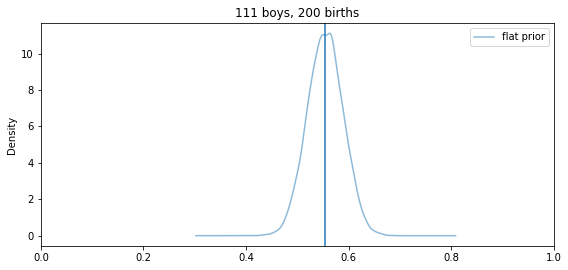

In [81]:
fig, ax = create_images_from_data(
    data={
        'title': '',
        'data': [
            [
                {
                    'title': f'{all_births.sum()} boys, {all_births.shape[0]} births',
                    'data': [
                        pd.DataFrame(flat_prior_model.prev_accepted_proposals).rename(
                            columns={
                                'beta': 'flat_prior_model'
                            }
                        )
                        
                    ]
                }
            ]
        ]
    },
    xlim=(0,1),
    figsize_mult=(8,4)
)
ax.axvline(flat_prior_model.prev_accepted_proposals.mean()[0])
#ax.axvline(0.7, color='r')


In [83]:
print(f"The maximum a posteriori (MAP) value is {flat_prior_model.prev_accepted_proposals.mean()[0]}")

The maximum a posteriori (MAP) value is 0.5546362717608132


## 3H2. 

Using the sample function, draw 10,000 random parameter values from the posterior distribution you calculated above. Use these samples to estimate the 50%, 89%, and 97% highest posterior  density intervals. 

In [86]:
{
    '50%': hpdi(proba=0.5, array=flat_prior_model.prev_accepted_proposals.values),
    '89%': hpdi(proba=0.89, array=flat_prior_model.prev_accepted_proposals.values),
    '97%': hpdi(proba=0.97, array=flat_prior_model.prev_accepted_proposals.values)
}

{'50%': (array([0.53114965]), array([0.57791444])),
 '89%': (array([0.49816926]), array([0.60932004])),
 '97%': (array([0.48025453]), array([0.62885232]))}

## 3H3.

Use rbinom to simulate 10,000 replicates of 200 births. You should end up with 10,000 numbers, each one a count of boys out of 200 births. Compare the distribution of predicted numbers  of boys to the actual count in the data (111 boys out of 200 births). There are many good ways to  visualize the simulations, but the dens command (part of the rethinking package) is probably the  easiest way in this case. Does it look like the model fits the data well? That is, does the distribution  of predictions include the actual observation as a central, likely outcome?

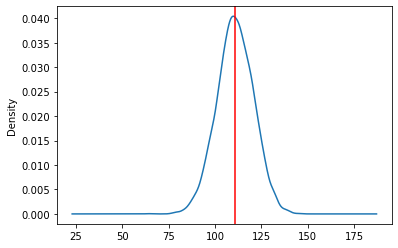

In [94]:
ax = pd.Series(
    np.random.binomial(n=200, p=flat_prior_model.prev_accepted_proposals).reshape(1,10000)[0]
).plot.kde()

ax.axvline(111, color='r')
          

Samples from the posterior distribution look centered at 111.

## 3H4. 

Now compare 10,000 counts of boys from 100 simulated first borns only to the number of boys  in the first births, birth1. How does the model look in this light? 

Text(0.5, 1.0, 'Posterior Prediction vs. Number of Sons')

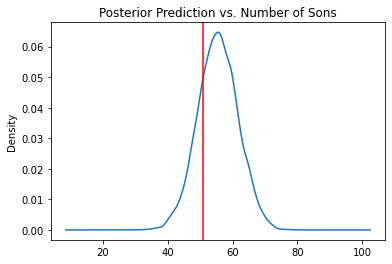

In [100]:
ax = pd.Series(
    np.random.binomial(n=100, p=flat_prior_model.prev_accepted_proposals).reshape(1,10000)[0]
).plot.kde()

ax.axvline(np.array(birth1).sum(), color='r')
ax.set_title("Posterior Prediction vs. Number of Sons")
          

Looks like the posterior distribution is skewed to the right of the count of the first born sons.

## 3H5. 

The model assumes that sex of first and second births are independent. To check this assumption, focus now on second births that followed female first borns. Compare 10,000 simulated counts  of boys to only those second births that followed girls. To do this correctly, you need to count the  number of first borns who were girls and simulate that many births, 10,000 times. Compare the  counts of boys in your simulations to the actual observed count of boys following girls. How does the  model look in this light? Any guesses what is going on in these data? 

In [106]:
num_births_where_first_birth_was_female = births[births['birth_1'] == 0]['birth_2'].count()
num_sons_after_female_first_birth = births[births['birth_1'] == 0]['birth_2'].sum()

Text(0.5, 1.0, 'Posterior Prediction vs. Number of Sons')

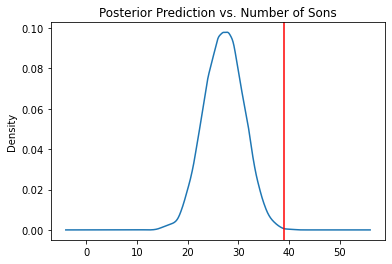

In [107]:
ax = pd.Series(
    np.random.binomial(
        n=num_births_where_first_birth_was_female, 
        p=flat_prior_model.prev_accepted_proposals
    ).reshape(1,10000)[0]
).plot.kde()

ax.axvline(num_sons_after_female_first_birth, color='r')
ax.set_title("Posterior Prediction vs. Number of Sons")
          

The model that assumes independence says that the data is unlikely. In some cultures, there is a preference for boys. Perhaps there were forced abortions that were not recorded (or at least some way for people to preferentially select a boy for the "second" birth).